In [2]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from framework.utils import *
from framework.data_fetcher import *
%matplotlib inline

# Comparing forecasts to FPL API values

The FPL API provides forecasts for the next gameweek. This notebook compares our forecasts to these.

In [3]:
plt.rcParams["figure.figsize"] = (10, 5)

In [4]:
tag = get_latest_prediction_tag()

In [5]:
our_preds = session.query(PlayerPrediction).all()
fpl_preds = FPLDataFetcher().get_player_summary_data()

In [7]:
positions = ["GK","DEF","MID","FWD"]
players = [(pid,pos) for pos in positions for pid in list_players(pos)]
fetcher = FPLDataFetcher()

In [9]:
def make_actual_row(pred): # pred is a tuple (playerid, position)
    df = pd.DataFrame()
    df["id"] = [pred[0]]
    df["position"] = [pred[1]]
    df["actual_points"] = [fetcher.get_gameweek_data_for_player(pred[0],5)[0]['total_points']]
    return df

def make_our_df_row(pred):
    df = pd.DataFrame()
    df["id"] = [pred.player_id]
    df["predicted_points"] = [pred.predicted_points]
    df["gameweek"] = [pred.gameweek]
    df["method"] = [pred.method]
    return df

def make_fpl_row(pred):
    df = pd.DataFrame()
    df["id"] = [pred["id"]]
    df["fpl_points"] = [float(pred["ep_next"])]
    df["gameweek"] = [5]
    df["name"] = get_player_name(pred["id"])
    return df

def make_pred_df(preds, kind="ours"):
    if kind == "ours":
        f = make_our_df_row
    elif kind == "fpl":
        f = make_fpl_row
        preds = preds.values()
    elif kind == "actual":
        f = make_actual_row
        preds = [(pid,pos) for pos in positions for pid in list_players(pos)]
    else:
        raise ValueError
    return pd.concat((f(pred) for pred in preds))

In [13]:
df_our_preds = make_pred_df(our_preds, kind="ours")
df_fpl_preds = make_pred_df(fpl_preds, kind="fpl")
df_actual = make_pred_df(players, kind="actual")
df_our_preds = df_our_preds[df_our_preds["gameweek"] == 5]
df_predictions = df_our_preds.merge(df_fpl_preds, left_on="id", right_on="id")
df_all = df_predictions.merge(df_actual, left_on="id", right_on="id")

Unknown player_id 538


/Users/nbarlow/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


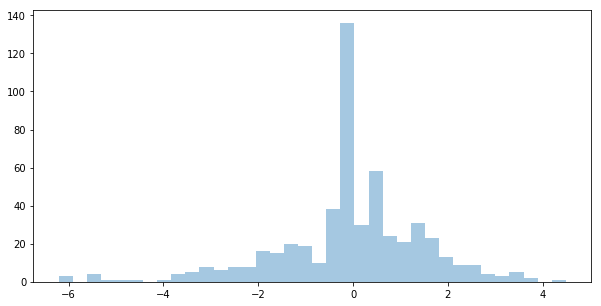

In [16]:
sns.distplot(df_all["predicted_points"] -  df_all["fpl_points"], kde=False);

/Users/nbarlow/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


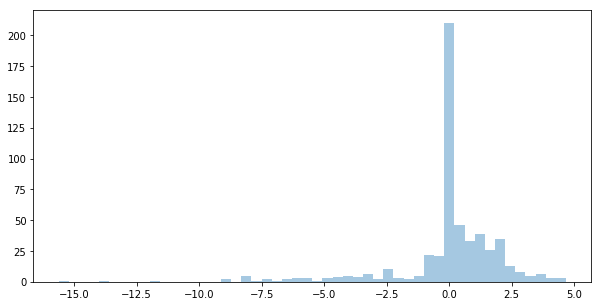

In [17]:
sns.distplot(df_all["predicted_points"] -  df_all["actual_points"], kde=False);

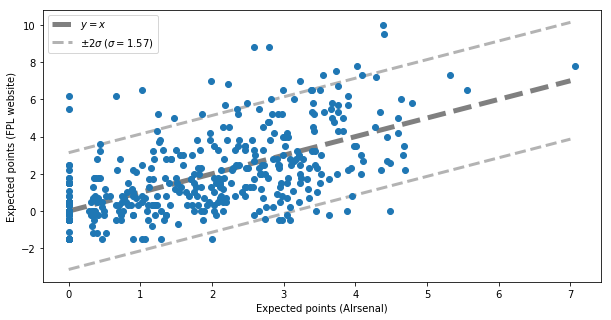

In [7]:
plt.scatter(df_all["predicted_points"].values, df_all["fpl_points"].values)
plt.xlabel("Expected points (AIrsenal)")
plt.ylabel("Expected points (FPL website)")
x = np.linspace(0., 7.)
std = np.std(df_all["predicted_points"] - df_all["fpl_points"])
plt.plot(x, x, ls="--", c='0.5', lw=5, zorder=0.0, label=r"$y = x$")
plt.plot(x, x + 2*std, ls="--", c='0.7', lw=3, zorder=0.0, label=r"$\pm 2\sigma\;(\sigma = {:.2f})$".format(std))
plt.plot(x, x - 2*std, ls="--", c='0.7', lw=3, zorder=0.0)
plt.legend();

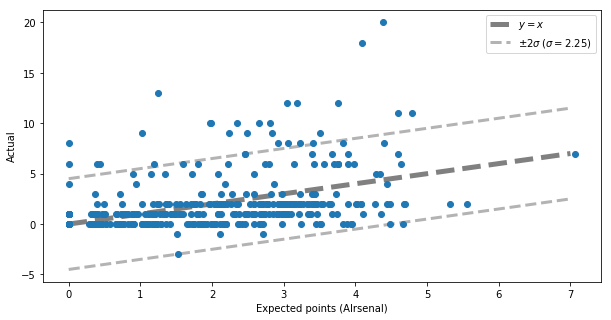

In [15]:
plt.scatter(df_all["predicted_points"].values, df_all["actual_points"].values)
plt.xlabel("Expected points (AIrsenal)")
plt.ylabel("Actual")
x = np.linspace(0., 7.)
std = np.std(df_all["predicted_points"] - df_all["actual_points"])
plt.plot(x, x, ls="--", c='0.5', lw=5, zorder=0.0, label=r"$y = x$")
plt.plot(x, x + 2*std, ls="--", c='0.7', lw=3, zorder=0.0, label=r"$\pm 2\sigma\;(\sigma = {:.2f})$".format(std))
plt.plot(x, x - 2*std, ls="--", c='0.7', lw=3, zorder=0.0)
plt.legend();